# 2. 임베딩

## 2.1 임베딩이란?

* `자연어를 숫자나 벡터형태로 변환하는 것`을 임베딩이라고 한다.
* 즉, 임베딩은 `단어나 문장을 수치화해서 벡터공간으로 표현하는 과정`을 의미한다.

##### 임베딩기법
1. 문장임베딩 : 여러개의 문장에서 각각의 문장을 벡터로 표현하는 기법
   - 문장의 흐름을 벡터화하기 때문에 문맥적의미를 가지는 장점이 있다.
   - 하지만, 문장을 임베딩하기 위해서는 많은 문장이 필요하며 학습비용이 많이 든다.
   - 상용시스템에서 많이 사용된다.(단어임베딩에 비해 품질이 우수하다.)
2. 단어임베딩 : 개별 단어를 벡터로 표현하는 기법
   - 동음의의어에 대한 구분을 하지 않는다. 
   - 그렇기 때문에 의미가 다르더라도 단어형태가 같다면 동일한 벡터값으로 표현하는 단점이 있다.
   - 하지만, 문장임베딩에 비해 학습이 간단하여 실무에 많이 사용된다.
  
## 2.2 단어임베딩

* 단어 인베딩은 말뭉치에서 각각의 단어를 벡터로 변환하는 기법을의미
* 참고 : https://wikidocs.net/33520

### 2.2.1 원핫인코딩(One-Hot Encoding)

* `단어를 숫자벡터로 변환하는 가장 기본적인 방법`
* 단 한 개의 값만 1이고 나머지는 0인 희소행렬
* 원핫인코딩의 결과를 원핫벡터라고 하고 `희소벡터(sparse vector), 희소행렬`이라고 한다.

In [5]:
# 원핫인코딩
import numpy as np
from konlpy.tag import Komoran

komoran = Komoran()

text = '오늘 날씨는 구름이 많아요'

# 명사만 추출
nouns = komoran.nouns(text)
print(nouns)

# 단어사전구축 및 단어별 인덱스를 부여
dics = {}
for word in nouns:
    if word not in dics.keys():
        dics[word] = len(dics)
print(dics)

# 단어벡터화 - 원핫인코딩
nb_classes = len(dics)
targets = list(dics.values())
print(nb_classes, targets)

['오늘', '날씨', '구름']
{'오늘': 0, '날씨': 1, '구름': 2}
3 [0, 1, 2]


In [12]:
# np.eye() : 원핫인코딩을 만들어 주는 함수
one_hot_targets = np.eye(nb_classes)[targets]
print(one_hot_targets)

# 결과
# [1. 0. 0.]이란 값이 입력이 되면 '오늘'이라고 인식한다.
# 원핫코딩의 메모리낭비와 계산의 복잡도가 커지는 단점이 있다.

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### 2.2.2 희소표현과 분산표현
* `희소표현은 희소벡터로 표현되는 방식, 분산표현 단어간의 유사성을 표현 하는 방법`
* 분산표현은 `데이터손실을 최소화 하면서 벡터차원을 압축하는 효과`가 있다.
* 분산표현을 원하는 차원에 데이터를 최대한 밀집시켜서 `밀집표현`이라고 한다.
* 참고 : http://bigdata.dongguk.ac.kr/lectures/TextMining/_book/분산표현.html

### 2.2.2 Word2Vec

* 신경망기반의 `단어임베팅의 대표적인 알고리즘`이다.
* Word2Vec은 2013년 구글에서 발표, 가장 많이 사용하는 모델이다.
* Word2Vec 모델은 `CBOW Continuos Bag Of Words`와 `skip-gram` 2가지 모델로 제안되었다.
  - CBOW는 `주변 단어를 이용해 타깃단어를 예츨하는 모델`
  - skip-gram은 CBOW와 반대로 `하나의 타깃단어를 이용해 주변단어를 예측하는 모델`
* Word2Vec은 `단어를 밀집벡터로 표현`하고 학습을 통해서 `유사한 단어를 가까운 벡터공간에 위치`시킨다.
* Word2Vec은 오픈소스라이브러리 `Gensim패키지를 사용`하고 `한국어말뭉치는 네이버영화리뷰데이터를 사용`
  1. gensim : pip install gensim
  2. 네이버영화리뷰데이터(Naver Sentiment Movie Corpus, NSMC)
     - 최신버전 : http://github.com/e9t/nsmc

In [14]:
!pip install gensim
!pip show gensim

Name: gensim
Version: 4.3.0
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: C:\Anaconda3\Lib\site-packages
Requires: FuzzyTM, numpy, scipy, smart-open
Required-by: 


In [15]:
from gensim.models import Word2Vec
from konlpy.tag import Komoran
import time

# 네이버영화리뷰데이터읽기
def read_review_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        dat = data[1:] # header부분을 제거
    return data

In [18]:
# 학습시간측정 - 시작시간
start = time.time()

# 1. 파일읽기
review_data = read_review_data('./data/chatbot/ratings.txt')
print(f'1) 말뭉치데이터 읽기 소요시간 = {time.time()-start}, 데이터처리건수 = {len(review_data)}')

# 2. 문장단위로 명사만 추출 - 학습을 위한 입력데이터로 사용
komoran = Komoran()
docs = [komoran.nouns(sentence[1]) for sentence in review_data]
print(f'2) 형태소에서 명사만 추출 소요시간 = {time.time()-start}, 데이터처리건수 = {len(docs)}')

1) 말뭉치데이터 읽기 소요시간 = 3.4857900142669678, 데이터처리건수 = 200001
2) 형태소에서 명사만 추출 소요시간 = 135.33001160621643, 데이터처리건수 = 200001


In [22]:
# 3. Word2Vec모델학습
# sentences : Word2Vec모델 학습에 필요한 문장 데이터
# vector_size : 단어 임베딩 벡터차원 크기
# window  : 주변 단어의 윈도우의 크기
# hs : 1(모델학습에 softmax 사용), 0(negative옵션값이 0이 아닐때 음수 샘플링을 사용)
# min_count : 단어 최소 빈도수 제한(설정된 빈도수이하의 단어들은 학습하지 않음)
# sg : 0(CBOW모델), 1(skip-gram)
start = time.time()
model = Word2Vec(sentences=docs, vector_size=200, window=4, min_count=2, sg=1)
print(f'3) Word2Vec 학습 소요시간 = {time.time()-start}')

3) Word2Vec 학습 소요시간 = 12.255795240402222


In [24]:
# 4. 모델저장
start = time.time()
model.save('./data/chatbot/nvmc.model')
print(f'4) Word2Vec 모델 저장시간 = {time.time()-start}')

4) Word2Vec 모델 저장시간 = 0.06812262535095215


In [28]:
# 5. 결과 - 학습된 말뭉치의 갯수, 말뭉치(코퍼스)내의 전체 단어 갯수
print(f'5) 학습된 말뭉치의 갯수 = {model.corpus_count}')
print(f'6) 말뭉치내의 전체 단어의 갯수 = {model.corpus_total_words}')

5) 학습된 말뭉치의 갯수 = 200001
6) 말뭉치내의 전체 단어의 갯수 = 1076896


In [31]:
# 6. 학습된 모델을 이용한 단어의 유사성
# 1) 학습된 모델을 로딩
model = Word2Vec.load('./data/chatbot/nvmc.model')

# 2) 사랑이란 단어로 생성한 단어의 임베딩된 벡터
print(f"1) 사랑 : {model.wv['사랑']}, \n 2) 사랑단어의 갯수 = {len(model.wv['사랑'])}")

1) 사랑 : [-0.10685623 -0.4085824   0.2668555   0.10199005  0.01058425 -0.03906837
 -0.35085934 -0.1273613  -0.1026871   0.587623   -0.00796239 -0.13266948
  0.26824802 -0.08237585 -0.27738976  0.40459165  0.09890487 -0.17377952
 -0.16290408 -0.28991842  0.4271538   0.47426897  0.10838524  0.27433047
 -0.34729716  0.02068822  0.13392577 -0.10570516  0.12598057 -0.24557832
  0.09198295  0.23060898  0.23707475 -0.11261325 -0.02460319  0.31747648
 -0.11580553 -0.09723865 -0.33355933  0.1371493  -0.1951848   0.29074258
 -0.10514318 -0.42389932  0.550583    0.26861376 -0.18041943 -0.10703591
  0.45252413  0.1925721   0.18853053 -0.21597807 -0.02059748 -0.08184987
  0.05668297 -0.10654421 -0.21920097 -0.31448537  0.1905136  -0.02320636
 -0.01440583  0.01435221 -0.5093042   0.0719338  -0.18555446 -0.09675293
 -0.28501663  0.0536319  -0.29481533  0.70011574  0.02206255 -0.02260146
  0.4384756   0.14988622  0.44350803  0.05337228  0.3614695  -0.3965798
 -0.16428077 -0.23198265  0.09343985 -0.0748

In [37]:
# 3) 단어의 유사도 : model.wv.similarity()함수
print(f"일요일과 월요일의 유사도 = {model.wv.similarity(w1='일요일', w2='월요일')}")
print(f"일요일과 사랑의 유사도 = {model.wv.similarity(w1='일요일', w2='사랑')}")
print(f"황정민과 배우의 유사도 = {model.wv.similarity(w1='황정민', w2='배우')}")
print(f"안성기와 사랑의 유사도 = {model.wv.similarity(w1='안성기', w2='사랑')}")
print(f"정우성과 사랑의 유사도 = {model.wv.similarity(w1='정우성', w2='사랑')}")
print(f"대기업과 삼성의 유사도 = {model.wv.similarity(w1='대기업', w2='삼성'):.3f}")
print(f"일요일과 삼성의 유사도 = {model.wv.similarity(w1='일요일', w2='삼성'):.3f}")

일요일과 월요일의 유사도 = 0.9156172871589661
일요일과 사랑의 유사도 = 0.41377878189086914
황정민과 배우의 유사도 = 0.6881183981895447
안성기와 사랑의 유사도 = 0.37100523710250854
정우성과 사랑의 유사도 = 0.3950616121292114
대기업과 삼성의 유사도 = 0.856
일요일과 삼성의 유사도 = 0.631


In [40]:
# 4) most_similar(str, topn) - 가장 유사한 단어를 추출
# topn = 5 : 5개까지 유사한 단어갯수
print(model.wv.most_similar("안성기", topn=5))
print(model.wv.most_similar("시리즈", topn=5))
print(model.wv.most_similar("사랑", topn=5))

[('지진희', 0.9554622173309326), ('최강희', 0.9476363062858582), ('설경구', 0.9458160996437073), ('한석규', 0.9434689283370972), ('김수로', 0.9405372142791748)]
[('엑스맨', 0.8226369023323059), ('포터', 0.8177784085273743), ('스타워즈', 0.7996784448623657), ('해리', 0.7912483215332031), ('미이라', 0.7891461849212646)]
[('사랑은', 0.7138580083847046), ('이별', 0.6957950592041016), ('사랑으로', 0.6892824172973633), ('상처', 0.6864337921142578), ('사랑이란', 0.6839547753334045)]


In [41]:
# 시각화
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 한글처리
plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False

In [51]:
print(f"안성기와 배우의 유사도 = {model.wv.similarity(w1='안성기', w2='배우')}")
print(f"안성기와 사랑의 유사도 = {model.wv.similarity(w1='안성기', w2='사랑')}")
print(f"사랑과 사랑의 유사도 = {model.wv.similarity(w1='사랑', w2='사랑')}")
print(f"사랑과 이별의 유사도 = {model.wv.similarity(w1='사랑', w2='이별')}")

안성기와 배우의 유사도 = 0.6981827020645142
안성기와 사랑의 유사도 = 0.37100523710250854
사랑과 사랑의 유사도 = 1.0
사랑과 이별의 유사도 = 0.6957951784133911


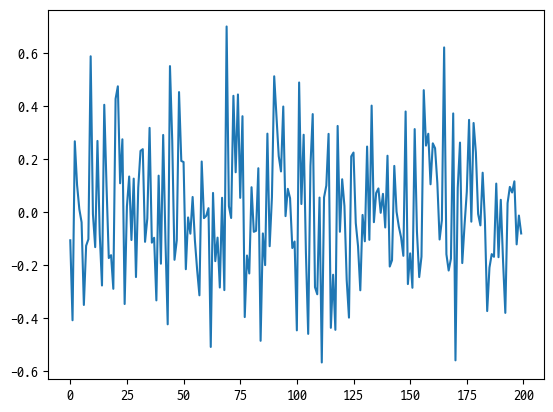

In [43]:
plt.plot(model.wv['사랑'])
plt.show()

# 결과분석
# 사랑이란 단어는 모든 차원에 골고루 분포되어 있는 것을 알 수가 있다.
# 즉, 사랑이란 단어는 모든 벡터와 관계가 있음을 유추할 수가 있다.
# 안성기라는 단어는 라는 단어와의 유사도가 70%, 사랑이란단어와의 유사도는 37%의 유사도가 있다.
# 유사도가 1.0에 가까울 수록 두 단어는 동일의미이거나 문법적 관계가 있을 확률이 높다.

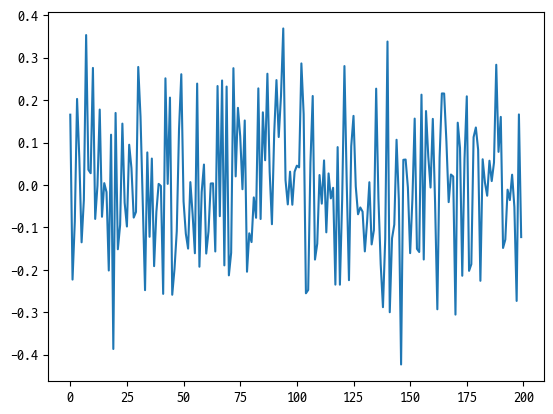

In [44]:
plt.plot(model.wv['안성기'])
plt.show()

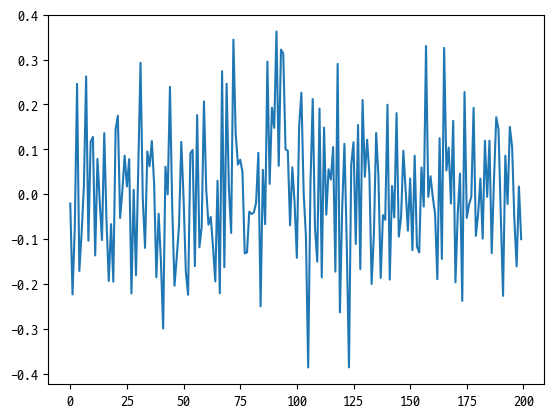

In [46]:
plt.plot(model.wv['요리'])
plt.show()